In [1]:
import copy
import pickle
import random
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from Bio import Align

from dataset import *
from utils import *
from models import *

# 1. cov-abdab

## 1.1 EDA

In [2]:
# data = pickle.load(open("../../MSAI_Project/codes/data_files/data.json", "rb"))
# data = pickle.load(open("../../MSAI_Project/codes/data_files/data_list.pkl", "rb"))
data = pickle.load(open("./data/data_list.pkl", "rb"))
type(data), len(data)

(list, 5386)

In [3]:
# must: delete samples with CDR containing "..."
data1 = []
for i in range(len(data)):
    if ("." in data[i]["H1"]) or ("." in data[i]["H2"]) or ("." in data[i]["H3"]) or ("." in data[i]["L1"]) or ("." in data[i]["L2"]) or ("." in data[i]["L3"]):
        pass
    else:
        data1.append(data[i])
        
del data
data = data1
del data1
type(data), len(data)

(list, 5380)

In [4]:
# check . existence
for i in range(len(data)):
    if ("." in data[i]["H1"]) or ("." in data[i]["H2"]) or ("." in data[i]["H3"]) or ("." in data[i]["L1"]) or ("." in data[i]["L2"]) or ("." in data[i]["L3"]):
        print("/".join([data[i]["H1"], data[i]["H2"], data[i]["H3"], data[i]["L1"], data[i]["L2"], data[i]["L3"]]))
        print(i)

# paratope max len
maxlen = 0
for i in range(len(data)):
    cur = len(data[i]["H1"]+data[i]["H2"]+data[i]["H3"]+data[i]["L1"]+data[i]["L2"]+data[i]["L3"])
    maxlen = cur if cur > maxlen else maxlen
print("max len of paratope:", maxlen)


# check integrity of six CDRs
for i in range(len(data)):
    s = "/".join([data[i]["H1"], data[i]["H2"], data[i]["H3"], data[i]["L1"], data[i]["L2"], data[i]["L3"]])
    if len(s.split("/"))!=6:
        print(s)

max len of paratope: 69


In [5]:
data[0].keys()

dict_keys(['pdb', 'Hchain', 'Lchain', 'Achain', 'Hseq', 'Lseq', 'Aseq', 'L1', 'L2', 'L3', 'H1', 'H2', 'H3'])

In [6]:
len(data[0]["Hseq"]["J"])

123

In [7]:
data[0]

{'pdb': '7t17',
 'Hchain': 'J',
 'Lchain': 'K',
 'Achain': ['C'],
 'Hseq': {'J': [{'name': 'GLN',
    'abbr': 'Q',
    'pos': array([[ 57.69 , -27.721, 213.695],
           [ 56.713, -27.938, 214.755],
           [ 56.848, -26.882, 215.848],
           [ 57.955, -26.464, 216.188]], dtype=float32)},
   {'name': 'VAL',
    'abbr': 'V',
    'pos': array([[ 55.708, -26.454, 216.394],
           [ 55.725, -25.461, 217.46 ],
           [ 56.083, -26.137, 218.776],
           [ 55.473, -27.138, 219.173]], dtype=float32)},
   {'name': 'GLN',
    'abbr': 'Q',
    'pos': array([[ 57.085, -25.589, 219.46 ],
           [ 57.561, -26.15 , 220.715],
           [ 57.666, -25.045, 221.754],
           [ 58.003, -23.902, 221.438]], dtype=float32)},
   {'name': 'LEU',
    'abbr': 'L',
    'pos': array([[ 57.37 , -25.4  , 223.002],
           [ 57.438, -24.472, 224.121],
           [ 58.445, -24.994, 225.135],
           [ 58.476, -26.192, 225.431]], dtype=float32)},
   {'name': 'GLN',
    'abbr': 'Q',
 

(array([  3.,   0.,   0.,   0.,   0.,   0.,  18.,   0.,   0.,  77.,   0.,
          0.,  27.,   0.,   0., 131.,   0.,   0., 149.,   0.,   0., 158.,
          0.,   0.,   0., 363.,   0.,   0., 452.,   0.,   0., 474.,   0.,
          0., 340.,   0.,   0., 388.,   0.,   0., 359.,   0.,   0., 356.,
          0.,   0., 336.,   0.,   0.,   0., 457.,   0.,   0., 265.,   0.,
          0., 277.,   0.,   0.,  92.,   0.,   0., 180.,   0.,   0.,  96.,
          0.,   0., 118.,   0.,   0.,  35.,   0.,   0.,   0.,  52.,   0.,
          0., 109.,   0.,   0.,  20.,   0.,   0.,  16.,   0.,   0.,  17.,
          0.,   0.,   2.,   0.,   0.,   5.,   0.,   0.,   6.,   0.,   0.,
          2.]),
 array([37.  , 37.32, 37.64, 37.96, 38.28, 38.6 , 38.92, 39.24, 39.56,
        39.88, 40.2 , 40.52, 40.84, 41.16, 41.48, 41.8 , 42.12, 42.44,
        42.76, 43.08, 43.4 , 43.72, 44.04, 44.36, 44.68, 45.  , 45.32,
        45.64, 45.96, 46.28, 46.6 , 46.92, 47.24, 47.56, 47.88, 48.2 ,
        48.52, 48.84, 49.16, 49.48

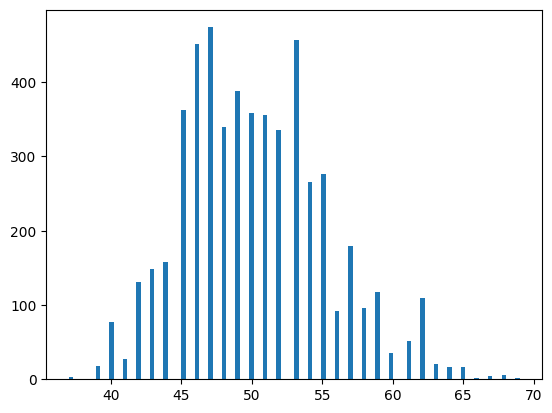

In [8]:
para_len = []
for i in range(len(data)):
    tmp = len(data[i]["L1"])+len(data[i]["L2"])+len(data[i]["L3"])+len(data[i]["H1"])+len(data[i]["H2"])+len(data[i]["H3"])
    para_len.append(tmp)
plt.hist(para_len, bins=100)

In [9]:
data[0]["Aseq"]["C"]

[{'name': 'ILE',
  'abbr': 'I',
  'pos': array([[ 81.858,  -7.199, 197.021],
         [ 81.735,  -6.449, 198.265],
         [ 80.284,  -6.421, 198.728],
         [ 79.74 ,  -5.362, 199.036]], dtype=float32)},
 {'name': 'ARG',
  'abbr': 'R',
  'pos': array([[ 79.66 ,  -7.596, 198.767],
         [ 78.278,  -7.837, 199.157],
         [ 77.269,  -7.526, 198.055],
         [ 76.075,  -7.745, 198.261]], dtype=float32)},
 {'name': 'CYS',
  'abbr': 'C',
  'pos': array([[ 77.695,  -7.022, 196.897],
         [ 76.793,  -6.774, 195.785],
         [ 77.323,  -7.296, 194.458],
         [ 76.538,  -7.469, 193.52 ]], dtype=float32)},
 {'name': 'ILE',
  'abbr': 'I',
  'pos': array([[ 78.63 ,  -7.552, 194.352],
         [ 79.196,  -8.074, 193.112],
         [ 78.916,  -9.554, 192.915],
         [ 78.921, -10.028, 191.772]], dtype=float32)},
 {'name': 'GLY',
  'abbr': 'G',
  'pos': array([[ 78.667, -10.296, 193.99 ],
         [ 78.411, -11.718, 193.885],
         [ 76.953, -12.063, 193.664],
         [ 

In [10]:
tmp = [data[0]["Aseq"][k] for k in data[0]["Aseq"]]
tmp = np.hstack(tmp)
# tmp = "/".join(tmp)
len(tmp)

392

(array([766., 232.,  43.,  92., 118., 241., 254., 229., 173., 133., 121.,
        171., 136., 121., 102., 136., 105., 152., 170., 104., 136.,  94.,
         73., 211., 128.,  95., 150.,  94.,  39., 148., 122.,  47.,  38.,
         41.,  25.,  18.,  20.,  17.,   7.,  10.,  23.,  15.,  19.,   6.,
          9.,   7.,  12.,   2.,   7.,   3.,  17.,  17.,   4.,  11.,  20.,
         12.,  11.,   4.,   2.,   9.,   5.,   7.,   5.,   7.,   6.,   0.,
          2.,   0.,   5.,   1.,   0.,   2.,   1.,   4.,   2.,   0.,   1.,
          0.,   1.,   0.,   0.,   1.,   0.,   2.,   0.,   1.,   1.,   0.,
          0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.]),
 array([   2.  ,   20.51,   39.02,   57.53,   76.04,   94.55,  113.06,
         131.57,  150.08,  168.59,  187.1 ,  205.61,  224.12,  242.63,
         261.14,  279.65,  298.16,  316.67,  335.18,  353.69,  372.2 ,
         390.71,  409.22,  427.73,  446.24,  464.75,  483.26,  501.77,
         520.28,  538.79,  557.3 ,

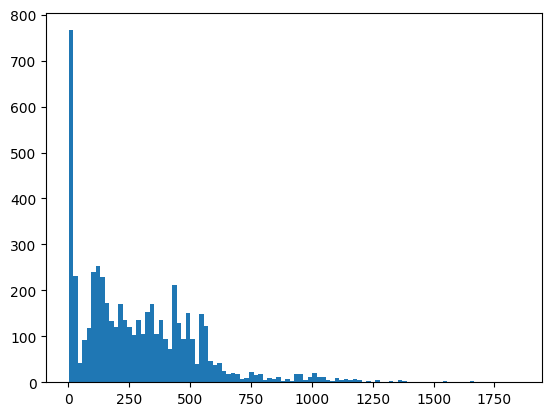

In [11]:
epi_len = []
for i in range(len(data)):
    tmp = [data[i]["Aseq"][k] for k in data[i]["Aseq"]]
    tmp = np.hstack(tmp)
    epi_len.append(len(tmp))
plt.hist(epi_len, bins=100)

(array([2.281e+03, 1.318e+03, 1.168e+03, 3.450e+02, 1.030e+02, 1.070e+02,
        3.800e+01, 1.100e+01, 7.000e+00, 2.000e+00]),
 array([   2. ,  187.1,  372.2,  557.3,  742.4,  927.5, 1112.6, 1297.7,
        1482.8, 1667.9, 1853. ]),
 <BarContainer object of 10 artists>)

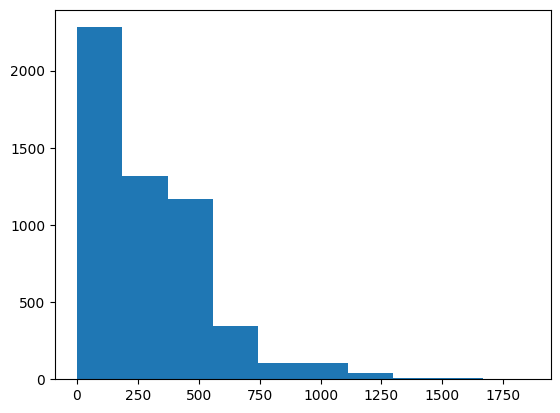

In [12]:
plt.hist(epi_len)

In [13]:
threshold = 400
print(len(epi_len))
sum([1 if epi_len[i]>threshold else 0 for i in range(len(epi_len))])

5380


1579

In [14]:
L1_len = []
L2_len = []
L3_len = []
H1_len = []
H2_len = []
H3_len = []
A_len = []

for i in range(len(data)):
    L1_len.append(len(data[i]["L1"]))
    L2_len.append(len(data[i]["L2"]))
    L3_len.append(len(data[i]["L3"]))
    H1_len.append(len(data[i]["H1"]))
    H2_len.append(len(data[i]["H2"]))
    H3_len.append(len(data[i]["H3"]))
    A_len.append(len("".join(data[i]["Aseq"])))
    # 3 antigen chains
    if len("".join(data[i]["Aseq"]))>=3:
        print(i)

49
96
117
128
179
241
407
438
488
517
527
532
554
609
615
672
813
1113
1176
1208
1216
1281
1322
1348
1381
1389
1397
1513
1590
1688
1694
1698
1702
1766
1781
1782
1796
2024
2088
2124
2131
2235
2247
2272
2386
2504
2627
2662
2693
2742
2808
2814
2898
2901
3062
3317
3331
3397
3486
3548
3598
3626
3667
3799
3920
3929
3988
4124
4222
4330
4334
4550
4626
4635
4643
4652
4666
4805
4895
4971
5035
5052
5077
5107
5113
5253
5278
5363


# debug

In [15]:
d = pickle.load(open("./data/processed_data_clip1_neg0.pkl", "rb"))
len(d)

7856

In [16]:
for i in range(len(d)):
    if "." in d[i][0] or "." in d[i][1]:
        print(i, d[i])

In [17]:
# need to remove redundant instances
# done below:
# 

## 1.2 dataset

## 1.3 Model

## 1.4 Training

In [18]:
# def my_pad_sequence(seqs):
#     max_len = max(list(map(lambda x:len(x), seqs)))
    
#     seqs = list(map(lambda x:"+"+x.strip("#")+"#"*(max_len-len(x.strip("#")))+"-", seqs))
    
#     return seqs

# def collate_fn(batch, mode=0):
    
#     # +ABCD-###
#     if mode==0:

#         paras = [b[0] for b in batch]
#         epis = [b[1] for b in batch]
#         labels = torch.hstack([b[2] for b in batch])
#         max_len = max(max(list(map(lambda x:len(x), paras))), max(list(map(lambda x:len(x), epis))))

#         paras = ["+"+i.strip("#")+"-"+"#"*(max_len-len(i.strip("#"))) for i in paras]
#         epis = ["+"+i.strip("#")+"-"+"#"*(max_len-len(i.strip("#"))) for i in epis]

#         new_batch = [paras, epis, labels]

#         return new_batch
    
#     # padding for six CDRs
#     if mode==1:
#         paras = [b[0] for b in batch]
#         paras = [(p.split("/"), max(list(map(lambda x:len(x), p.split("/"))))) for p in paras]
#         paras = list(map(my_pad_sequence, paras))
#         epis = [b[1] for b in batch]
#         labels = [b[2] for b in batch]
#         new_batch = [paras, epis, labels]

#         return new_batch

In [19]:
# config = {
#     'kfold': 10,          # 0 - full; 5 - 5fold; 10 - 10fold
#     'seq_clip_mode': 1,   # how to choose epitope: 0 - random AA sequence as epitope; 1 - k-nearest AA as epitope
#     'neg_sample_mode': 0, # how to generate negative sample: 0 - random sample with dissimilarity rate 90% 1 - random sequence;
    
#     'model_name': 'lstm'
#     'embed_size': 32, 
#     'hidden': 64, 
    
#     'batch_size': 16, 
#     'clip_norm': 1
# }

In [25]:
para_len = 72
epi_len = 48
hidden = 64 #128 #64
embed_size = 32 #16 #64
kfold = 10


# how to choose epitope: 0 - random AA sequence as epitope; 1 - k-nearest AA as epitope
seq_clip_mode = 1 #0
# how to generate negative sample: 0 - random sample with dissimilarity rate 90% 1 - random sequence;
neg_sample_mode = 0 #1

data_type = "seq" + str(seq_clip_mode) + "_" + "neg" + str(neg_sample_mode)

batch_size = 16 #128 #16
clip_norm = 1 # gradient clipping


# folds_path = None
folds_path = "./data/processed_data_clip1_neg0.pkl"


# model name
# model_name = "demo"
# model_name = "lstm"
# model_name = "mlp"
# model_name = "InteractTransformer"
# model_name = "InteractTransformerLSTM"
# model_name = "SetTransformer"
model_name = "SetModel"
# model_name = "SetModel_ablation"

os.makedirs("./results/SAbDab/{}/{}/".format(data_type, model_name), exist_ok=True)


for k_iter in range(kfold):
    
    print("=========================================================")
    print("fold {} as val set".format(k_iter))
    
    train_dataset = SAbDabDataset(data=data, epi_seq_length=epi_len, \
                                  seq_clip_mode=seq_clip_mode, neg_sample_mode=neg_sample_mode, \
                                  kfold=kfold, holdout_fold=k_iter, is_train_test_full="train", is_shuffle=False, \
                                  folds_path=folds_path, save_path=None, K=48, data_augment=False, augment_ratio=0.5)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, \
                                               collate_fn=collate_fn)

    test_dataset = SAbDabDataset(data=data, epi_seq_length=epi_len, \
                                 seq_clip_mode=seq_clip_mode, neg_sample_mode=neg_sample_mode, \
                                 kfold=kfold, holdout_fold=k_iter, is_train_test_full="val", is_shuffle=False, \
                                 folds_path="./data/processed_data_clip{}_neg{}.pkl".format(seq_clip_mode, neg_sample_mode), \
                                 save_path=None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, \
                                              collate_fn=collate_fn)
    
    if model_name=="demo":
        model = BiLSTM_demo(embed_size=32, hidden=64, num_layers=1, dropout=0.5, use_pretrain=False).cuda()
        epochs = 100
        lr = 6e-5

    elif model_name=="lstm":
        model = BiLSTM(embed_size=32, hidden=64, num_layers=1, dropout=0.5, use_pretrain=False).cuda()
        epochs = 100
        lr = 6e-5
    
    elif model_name=="mlp":
        model = BiMLP(embed_size=embed_size, hidden=hidden, num_layers=1, dropout=0.1, use_pretrain=False).cuda()
        epochs = 100
        lr = 1e-2
    
    elif model_name=="InteractTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.3).cuda()
        epochs = 1000
        lr = 6e-5
        
    elif model_name=="InteractTransformerLSTM":
        model = InteractTransformerLSTM(embed_size=32, 
                                        hidden=64, 
                                        num_encoder_layers=1, 
                                        num_lstm_layers=1, 
                                        nhead=2, 
                                        dropout=0.5, 
                                        use_coattn=False).cuda()
        epochs = 150
        lr = 6e-5
        
    elif model_name=="SetTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=64, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5).cuda()
        epochs = 200
        lr = 1e-4
        
        
    elif model_name=="SetModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=True, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 1000
        lr = 3e-5
        
    elif model_name=="SetModel_ablation":
        model = SetModel_ablation(embed_size=32, 
                         hidden=64, 
                         num_layers=2, 
                         dropout=0.5, 
                         k4kmer=7, 
                         use_pretrain=False, 
                         use_coattn=False, 
                         use_kmer_embed=True, 
                         use_seq_encoder=False, 
                         seq_encoder_type="lstm", 
                         num_heads=4, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 150
        lr = 6e-5

    else:
        pass
    
#     model = AlternateCoattnModel(embed_size=embed_size, seq_length=para_len, num_alternates=3, dropout=0.1).cuda()

    print("model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6, last_epoch=-1)

    loss_buf = []
    val_loss_buf = []
    val_acc_buf = []
    val_f1_buf = []
    val_auc_buf = []
    best_val_loss = float("inf")
    
    for epoch in range(epochs):

        loss_tmp = []
        for i, (para, epi, label) in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()

            pred = model(para, epi)

            loss = criterion(pred.view(-1), label.view(-1).cuda())

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)

            optimizer.step()

            loss_tmp.append(loss.item())
        
        loss_buf.append(np.mean(loss_tmp))

    #     scheduler.step()
        print("lr: ", optimizer.param_groups[0]['lr'])

        with torch.no_grad():

            model.eval()

            preds = []
            labels = []
            val_loss_tmp = []
            for i, (para, epi, label) in enumerate(tqdm(test_loader)):

                pred = model(para, epi)
                val_loss = criterion(pred.view(-1), label.view(-1).cuda())

                preds.append(pred.detach().cpu().view(-1))
                labels.append(label.view(-1))
                val_loss_tmp.append(val_loss.item())
            
            preds = torch.hstack(preds).view(-1)
            labels = torch.hstack(labels).view(-1)

            acc = accuracy_score(y_true=labels, y_pred=torch.round(preds))
            f1 = f1_score(y_true=labels, y_pred=torch.round(preds))
            auc = roc_auc_score(y_true=labels, y_score=preds)

            val_acc_buf.append(acc)
            val_f1_buf.append(f1)
            val_auc_buf.append(auc)
            val_loss_buf.append(np.mean(val_loss_tmp))

            print("Epoch {}: \n Train Loss\t{:.4f} \n Val Loss\t{:.4f} \n Val Acc\t{:.4f} \n Val F1\t\t{:.4f} \n Val AUC\t{:.4f}".format(epoch, np.mean(loss_buf), np.mean(val_loss_buf), acc, f1, auc))
            
            if np.mean(val_loss_tmp)<best_val_loss:
                best_val_loss = np.mean(val_loss_tmp)
                torch.save(model, "./results/SAbDab/{}/{}/model_{}_best.pth".format(data_type, model_name, k_iter))
                np.save("./results/SAbDab/{}/{}/val_acc_{}_best.npy".format(data_type, model_name, k_iter), acc)
                np.save("./results/SAbDab/{}/{}/val_f1_{}_best.npy".format(data_type, model_name, k_iter), f1)
                np.save("./results/SAbDab/{}/{}/val_auc_{}_best.npy".format(data_type, model_name, k_iter), auc)

        torch.cuda.empty_cache()
                
        model.train()
        

    
    torch.save(model, "./results/SAbDab/{}/{}/model_{}.pth".format(data_type, model_name, k_iter))
    np.save("./results/SAbDab/{}/{}/loss_buf_{}.npy".format(data_type, model_name, k_iter), np.array(loss_buf))
    np.save("./results/SAbDab/{}/{}/val_loss_buf_{}.npy".format(data_type, model_name, k_iter), np.array(val_loss_buf))
    np.save("./results/SAbDab/{}/{}/val_acc_buf_{}.npy".format(data_type, model_name, k_iter), np.array(val_acc_buf))
    np.save("./results/SAbDab/{}/{}/val_f1_buf_{}.npy".format(data_type, model_name, k_iter), np.array(val_f1_buf))
    np.save("./results/SAbDab/{}/{}/val_auc_buf_{}.npy".format(data_type, model_name, k_iter), np.array(val_auc_buf))
    
    
#     break

fold 0 as val set
loading preprocessed data from ./data/processed_data_clip1_neg0.pkl
loading preprocessed data from ./data/processed_data_clip1_neg0.pkl
model parameters:  82979


100%|████████████████████████████████████████| 442/442 [00:01<00:00, 316.77it/s]


lr:  6e-05


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1086.13it/s]


Epoch 0: 
 Train Loss	0.6347 
 Val Loss	0.8089 
 Val Acc	0.5427 
 Val F1		0.0000 
 Val AUC	0.5129


100%|████████████████████████████████████████| 442/442 [00:01<00:00, 316.78it/s]


lr:  6e-05


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1050.75it/s]


Epoch 1: 
 Train Loss	0.6245 
 Val Loss	0.8066 
 Val Acc	0.5427 
 Val F1		0.0000 
 Val AUC	0.5241


 29%|███████████▌                            | 128/442 [00:00<00:00, 324.19it/s]


KeyboardInterrupt: 

In [ ]:
model

In [30]:
for batch in train_loader:
    break
batch

[['+GGSISSGDSY/IYYSGST/ARHVGDLRVNDAFDI/SSNIGNNF/DSD/GTWDRSLSVVV-########',
  '+GGSISSGDSY/IYYSGST/ARHVGDLRVNDAFDI/SSNIGNNF/DSD/GTWDRSLSVVV-########',
  '+GGSISSGDSY/IYYSGST/ARHVGDLRVNDAFDI/SSNIGNNF/DSD/GTWDRSLSVVV-########',
  '+GGSISSGDSY/IYYSGST/ARHVGDLRVNDAFDI/SSNIGNNF/DSD/GTWDRSLSVVV-########',
  '+GFSLSSYP/IGTSGNI/ARGLYNDYTV/QSVYNKNY/SAS/LGSYDQAAHA-################',
  '+GFSLSSYP/IGTSGNI/ARGLYNDYTV/QSVYNKNY/SAS/LGSYDQAAHA-################',
  '+GYTFTAYY/INPNTGDT/AKDLTLMYVFDSGWARGAHDYYGMDV/NSDVGTFDL/EGS/SSYAGSVV-',
  '+GYTFTAYY/INPNTGDT/AKDLTLMYVFDSGWARGAHDYYGMDV/NSDVGTFDL/EGS/SSYAGSVV-',
  '+GDSISTNNG/INGRSGST/AFFWSTYYKRFDV/QSVDSR/DVS/HQENDWPWT-##############',
  '+GDSISTNNG/INGRSGST/AFFWSTYYKRFDV/QSVDSR/DVS/HQENDWPWT-##############',
  '+GFAFSSFG/ISSGSGTI/VRSIYYYGSSPFDF/KSLLHSNGNTY/RMS/MQHLEYPLT-#########',
  '+GFAFSSFG/ISSGSGTI/VRSIYYYGSSPFDF/KSLLHSNGNTY/RMS/MQHLEYPLT-#########',
  '+GFTFSDYG/ISNMAYSI/TRAIFDYAGYWYFDV/ESVEYYGTSL/GAS/QQSTKVPWT-#########',
  '+GFTFSDYG/ISNMAYSI/TRA

In [31]:
for batch in test_loader:
    break
batch

[['+GYTFTRYW/IYPGSNIT/AREGIYDGYFPLFPY/SSVSSGN/RTS/QQWSGYPWT-#####',
  '+GYSFTSYW/VYPGDSHT/TRSGFDYGNED/ESVDSYGNSF/RAS/QQSNEDPYT-######',
  '+GYSFTSYW/VYPGDSHT/TRSGFDYGNED/ESVDSYGNSF/RAS/QQSNEDPYT-######',
  '+GYTFTRFG/ISGYTGDT/VRNRVQMEVSPATQSTWYMDL/QDISRW/AAS/QQGSTFPYT-',
  '+GYTFTDYY/IVPNNGDT/ARFSNYVYPFDY/QDISNF/YTS/QQGNTLPLT-#########',
  '+GYTFTDYY/IVPNNGDT/ARFSNYVYPFDY/QDISNF/YTS/QQGNTLPLT-#########',
  '+GYTFTGYY/INPNSGDT/ARWDWGQYWFFDL/QSVRSSY/GAS/QHMYT-###########',
  '+GFPMSESYF/VIHTGTT/VRIRGGSSNWLDP/DSILRSAF/DDR/AAWNGRLSAFV-####',
  '+GFPMSESYF/VIHTGTT/VRIRGGSSNWLDP/DSILRSAF/DDR/AAWNGRLSAFV-####',
  '+GFTFSDAW/IRNKVNNHAT/TGLTFDY/ESVDNYGISS/AAS/QQSKGVPYT-########',
  '+GFTLSSYQ/ITGRGGVT/AKPALDSDQCGFPEAGCIDA/DSYY/GND/GAYDSSGGGGI-#',
  '+GFAFSSFG/ISSGSGTI/VRSIYYYGSSPFDF/KSLLHSNGNTY/RMS/MQHLEYPLT-##',
  '+GFAFSSFG/ISSGSGTI/VRSIYYYGSSPFDF/KSLLHSNGNTY/RMS/MQHLEYPLT-##',
  '+GFTFSSYP/INNGGGNP/IRQYYGFDY/QTIVHSNGKIY/RVS/FQGSHVPWT-#######',
  '+GYTFTDYY/ISPYNGGT/VYDLYYFDY/QRISND/YAS/QQSNS

In [32]:
len(train_dataset), len(test_dataset)

(7065, 785)

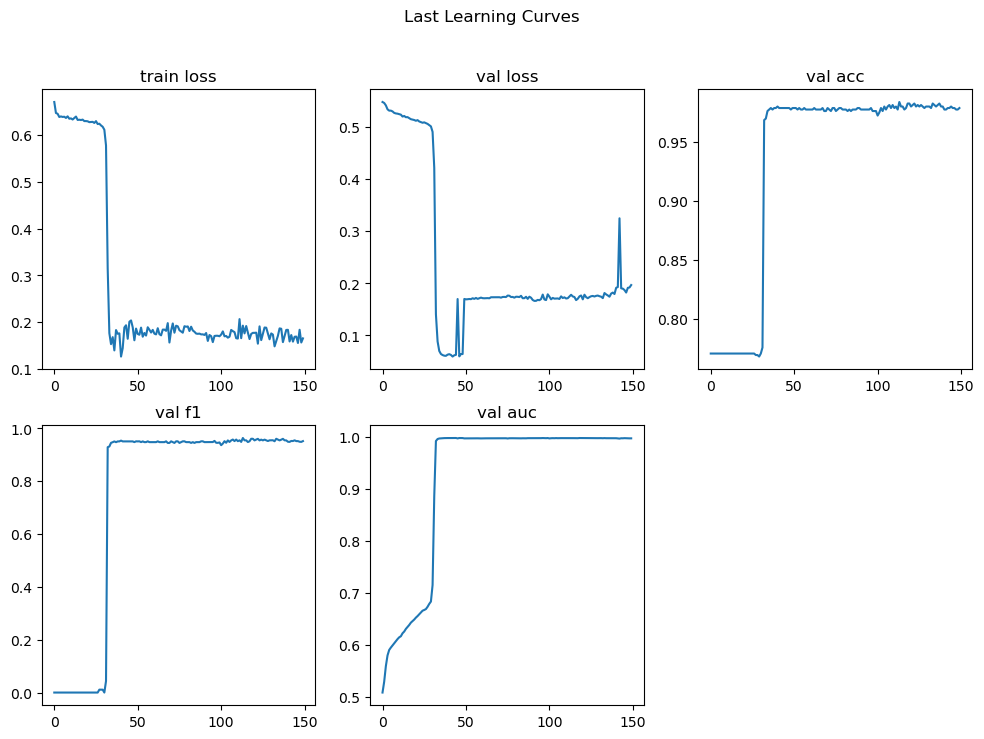

In [33]:
plt.figure(figsize=(12,8))

plt.subplot(231)
plt.plot(loss_buf)
plt.title("train loss")

plt.subplot(232)
plt.plot(val_loss_buf)
plt.title("val loss")

plt.subplot(233)
plt.plot(val_acc_buf)
plt.title("val acc")

plt.subplot(234)
plt.plot(val_f1_buf)
plt.title("val f1")

plt.subplot(235)
plt.plot(val_auc_buf)
plt.title("val auc")

plt.suptitle("Last Learning Curves")
plt.show()

In [34]:
val_acc_mean = []
val_f1_mean = []
val_auc_mean = []

for i in range(10):
    
    val_acc_i = np.load("./results/SAbDab/{}/{}/val_acc_{}_best.npy".format(data_type, model_name, i))
    val_acc_mean.append(val_acc_i)
    
    val_f1_i = np.load("./results/SAbDab/{}/{}/val_f1_{}_best.npy".format(data_type, model_name, i))
    val_f1_mean.append(val_f1_i)
    
    val_auc_i = np.load("./results/SAbDab/{}/{}/val_auc_{}_best.npy".format(data_type, model_name, i))
    val_auc_mean.append(val_auc_i)
    
    break
    
print("val acc mean: ", np.mean(val_acc_mean))
print("val f1 mean: ", np.mean(val_f1_mean))
print("val auc mean: ", np.mean(val_auc_mean))

val acc mean:  0.9732484076433121
val f1 mean:  0.9703808180535965
val auc mean:  0.9960178900702265


BiLSTM
- val acc mean:  0.9752300070771409
- val f1 mean:  0.9596004547190097
- val auc mean:  0.9961982339896467

demo - BiLSTM + remove "/"
- val acc mean:  0.9753715498938429
- val f1 mean:  0.9598416847843452
- val auc mean:  0.9965583867631231

InteractTransformer
- non-convergence @ first 10 epochs

InteractTransformerLSTM
- val acc mean:  0.9732484076433121
- val f1 mean:  0.9703808180535965
- val auc mean:  0.9960178900702265

SetTransformer
- val acc mean:  0.6771408351026185
- val f1 mean:  0.04578574402452007
- val auc mean:  0.5926709617479097

SetModel
- val acc mean:  0.9732484076433122
- val f1 mean:  0.9560846468263452
- val auc mean:  0.9952099378558822

SetModel_ablation
- use kmer & no seq_encoder
- val acc mean:  0.6771408351026186
- val f1 mean:  0.07555667240028481
- val auc mean:  0.6110399605027198

### BiLSTM

5fold

SAbDab: random AA for epitope seq_clip_mode=1

- 负样本-数据集中随机采样 neg_sample_mode=0
- val acc mean:  0.5003266448903407
- val f1 mean:  0.4014024178914616


- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.7940270648623425
- val f1 mean:  0.765332158051016

use_pretrain
seq1 neg0
- 

### InteractTransformer

10fold

- CoV-AbDab [参数量 115571]
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017

5fold

SAbDab: random AA for epitope seq_clip_mode=0

- 负样本-数据集中随机采样 neg_sample_mode=0
- val acc mean:  0.5050863275781614
- val f1 mean:  0.26889531502460473
- 应当比随机序列做样本更难，因为抗体序列间的差异很小，只在关键区域有差异；其次是随机的AA所以序列不完整且没有生物意义，导致难分类；


- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.8476901539897341
- val f1 mean:  0.8243978319230338
- 随机序列作为负样本用于测试可能不鲁棒，模型可能学得烂但测得高 -- 如何评估？-> 取k近邻的AA为epitope，该数据应当具有意义

5fold

SAbDab: k-nearest AA for epitope seq_clip_mode=1

- 负样本-数据集中随机采样 neg_sample_mode=0
- val acc mean:  0.5047130191320578
- val f1 mean:  0.3031313875079131


- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.7128324778348111
- val f1 mean:  0.6669602710083161
- 存在过拟合导致崩掉的现象 (e.g. epoch1、epoch10)
- share modules [参数量 634930]
- val acc mean:  0.5620158656089593
- val f1 mean:  0.5473767284795179

### BiInteractTransformer

5fold

SAbDab: k-nearest AA for epitope seq_clip_mode=1

- 负样本-数据集中随机采样 neg_sample_mode=0
- val acc mean:  0.5009799346710219
- val f1 mean:  0.44771116164979696


- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.6001866542230518
- val f1 mean:  0.7264313877322651
- share modules [参数量 1267059]
- val acc mean:  0.8121325244983668
- val f1 mean:  0.8445375055084579

### InteractCoattnTransformer

5fold

SAbDab: k-nearest AA for epitope seq_clip_mode=1

- 负样本-数据集中随机采样 neg_sample_mode=0
- [参数量 367858]
- val acc mean:  0.50648623425105
- val f1 mean:  0.47167367326203075


- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.561455902939804
- val f1 mean:  0.4968735319816034
- share modules [参数量 647410]
- val acc mean:  0.7028464769015399
- val f1 mean:  0.6089746640207852
- share modules [参数量 251122]
- val acc mean:  0.643210452636491
- val f1 mean:  0.6049936565494491

### SetTransformer

5fold

SAbDab: k-nearest AA for epitope seq_clip_mode=1

- 负样本-数据集中随机采样 neg_sample_mode=0
- val acc mean:  0.5085394307046197
- val f1 mean:  0.45360035038396046


- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.9564162389174055
- val f1 mean:  0.9517408054109368

### SetCoAttnTransformer

5fold

SAbDab: k-nearest AA for epitope seq_clip_mode=1

- 负样本-数据集中随机采样 neg_sample_mode=0



- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.9985067662155857
- val f1 mean:  0.9985067657686753

### AlternateCoAttnModel

1 & 0
- val acc mean:  0.5012599160055997
- val f1 mean:  0.24524917697199666

# full training

In [20]:
def evaluate(model_name, data_type="seq1_neg0"):
    
    print("======================================")
    print("=================={}================".format(model_name))
    print("======================================")
    
    val_acc = np.load("./results/SAbDab/full/{}/{}/val_acc_buf.npy".format(data_type, model_name))
    val_f1 = np.load("./results/SAbDab/full/{}/{}/val_f1_buf.npy".format(data_type, model_name))
    val_auc = np.load("./results/SAbDab/full/{}/{}/val_auc_buf.npy".format(data_type, model_name))
    
    
    plt.figure(figsize=(12,8))

    plt.subplot(231)
    plt.plot(loss_buf)
    plt.title("train loss")

    plt.subplot(232)
    plt.plot(val_loss_buf)
    plt.title("val loss")

    plt.subplot(233)
    plt.plot(val_acc_buf)
    plt.title("val acc")

    plt.subplot(234)
    plt.plot(val_f1_buf)
    plt.title("val f1")

    plt.subplot(235)
    plt.plot(val_auc_buf)
    plt.title("val auc")

    plt.suptitle("Last Learning Curves")
    plt.show()


    val_acc = np.load("./results/SAbDab/full/{}/{}/val_acc_best.npy".format(data_type, model_name))

    val_f1 = np.load("./results/SAbDab/full/{}/{}/val_f1_best.npy".format(data_type, model_name))

    val_auc = np.load("./results/SAbDab/full/{}/{}/val_auc_best.npy".format(data_type, model_name))


    print("val acc mean: ", np.mean(val_acc))
    print("val f1 mean: ", np.mean(val_f1))
    print("val auc mean: ", np.mean(val_auc))

In [ ]:
para_len = 72
epi_len = 48
hidden = 64 #128 #64
embed_size = 32 #16 #64


# how to choose epitope: 0 - random AA sequence as epitope; 1 - k-nearest AA as epitope
seq_clip_mode = 1 #0
# how to generate negative sample: 0 - random sample with dissimilarity rate 90% 1 - random sequence;
neg_sample_mode = 0 #1

data_type = "seq" + str(seq_clip_mode) + "_" + "neg" + str(neg_sample_mode)

batch_size = 16 #128 #16
clip_norm = 1 # gradient clipping


# folds_path = None
folds_path = "./data/processed_data_clip1_neg0.pkl"


# model name
# model_name = "demo"
# model_name = "lstm"
# model_name = "mlp"
# model_name = "InteractTransformer"
# model_name = "InteractTransformerLSTM"
# model_name = "SetTransformer"
# model_name = "SetModel"
# model_name = "SetModel_ablation"
# model_name = "EnsembleModel"
model_name = "PESI"

# model_list = ["masonscnn", 
#               "lstm", 
#               "InteractTransformer", 
#               "InteractCoAttnTransformer", 
#               "InteractTransformerLSTM", 
#               "SetTransformer", 
#               "SetCoAttnTransformer", 
#               "SetModel", 
#               "SetCoAttnModel"]

# for model_name in model_list:
for model_name in ["PESI"]:

    print("training {} on SAbDab-full".format(model_name))
    
    os.makedirs("./results/SAbDab/full/{}/{}/".format(data_type, model_name), exist_ok=True)


    train_dataset = SAbDabDataset(data=data, epi_seq_length=epi_len, \
                                  seq_clip_mode=seq_clip_mode, neg_sample_mode=neg_sample_mode, \
                                  is_train_test_full="full", is_shuffle=True, \
                                  folds_path=folds_path, save_path=None, K=48, data_augment=False)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, \
                                               collate_fn=collate_fn)

    test_dataset = SeqDataset(data_path="../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv", \
                              is_train_test_full="full")
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, \
                                               collate_fn=collate_fn)

    if model_name=="masonscnn":
        model = MasonsCNN(amino_ft_dim=len(vocab), 
                          max_antibody_len=100, 
                          max_virus_len=100, 
                          h_dim=512, 
                          dropout=0.1).cuda()
        epochs = 100
        lr = 1e-4

    elif model_name=="lstm":
        model = BiLSTM(embed_size=32, 
                       hidden=64, 
                       num_layers=1, 
                       dropout=0.5, 
                       use_pretrain=False).cuda()

        epochs = 300
        lr = 1e-4

    elif model_name=="InteractTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.3).cuda()
        epochs = 500
        lr = 6e-5
        
    elif model_name=="InteractCoAttnTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.5, 
                                    use_coattn=True).cuda()
        epochs = 500
        lr = 6e-5

    elif model_name=="InteractTransformerLSTM":
        model = InteractTransformerLSTM(embed_size=32, 
                                        hidden=64, 
                                        num_encoder_layers=1, 
                                        num_lstm_layers=1, 
                                        nhead=2, 
                                        dropout=0.5, 
                                        use_coattn=False).cuda()
        epochs = 500
        lr = 6e-5

    elif model_name=="SetTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=128, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5, 
                               use_coattn=False, 
                               share=False).cuda()
        epochs = 500
        lr = 6e-5
        l2_coef = 5e-4
        
    elif model_name=="SetCoAttnTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=128, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5, 
                               use_coattn=True, 
                               share=False).cuda()
        epochs = 500
        lr = 6e-5
        l2_coef = 5e-4

    elif model_name=="SetModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=False, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 500
        lr = 3e-5
        
    elif model_name=="SetCoAttnModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=True, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 500
        lr = 3e-5
        
    elif model_name=="EnsembleModel":
        model = EnsembleModel(embed_size=16, 
                      hidden=64, 
                      max_len=100, 
                      num_encoder_layers=1, 
                      num_heads=2, 
                      num_inds=6, 
                      num_outputs=6, 
                      ln=False, 
                      dropout=0.5, 
                      use_coattn=False).cuda()
        
        epochs = 500
        lr = 6e-5
        
#     elif model_name=="EnsembleModel1":
#         model = EnsembleModel(embed_size=16, 
#                       hidden=64, 
#                       max_len=100, 
#                       num_encoder_layers=1, 
#                       num_heads=2, 
#                       num_inds=6, 
#                       num_outputs=6, 
#                       ln=True, 
#                       dropout=0.5, 
#                       use_coattn=True).cuda()
        
#         epochs = 500
#         lr = 3e-5

    elif model_name=="PESI":
        model = PESI(embed_size=8, 
                     hidden=64, 
                     max_len=100, 
                     num_heads=2, 
                     num_inds=6, 
                     num_outputs=6, 
                     ln=True, 
                     dropout=0.5, 
                     use_coattn=True).cuda()
        
        epochs = 200
        lr = 5e-5
        l2_coef = 5e-4

    else:
        pass


    print("model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6, last_epoch=-1)

    loss_buf = []
    val_loss_buf = []
    val_acc_buf = []
    val_f1_buf = []
    val_auc_buf = []
    best_val_loss = float("inf")

    for epoch in range(epochs):

        print("Epoch {}".format(epoch))

        loss_tmp = []
        for i, (para, epi, label) in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()

            pred = model(para, epi)

            loss = criterion(pred.view(-1), label.view(-1).cuda())
            
            param_l2_loss = 0
            for name, param in model.named_parameters():
                if 'bias' not in name:
                    param_l2_loss += torch.norm(param, p=2)
            param_l2_loss = l2_coef * param_l2_loss
            loss += param_l2_loss

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)

            optimizer.step()

            loss_tmp.append(loss.item())

        loss_buf.append(np.mean(loss_tmp))

    #     scheduler.step()
        print("lr: ", optimizer.param_groups[0]['lr'])
        print("train loss {:.4f}\n".format(np.mean(loss_buf)))

        with torch.no_grad():

            model.eval()

            preds = []
            labels = []
            val_loss_tmp = []
            for i, (para, epi, label) in enumerate(tqdm(test_loader)):

                pred = model(para, epi)
                val_loss = criterion(pred.view(-1), label.view(-1).cuda())

                preds.append(pred.detach().cpu().view(-1))
                labels.append(label.view(-1))
                val_loss_tmp.append(val_loss.item())

            preds = torch.hstack(preds).view(-1)
            labels = torch.hstack(labels).view(-1)

            acc = accuracy_score(y_true=labels, y_pred=torch.round(preds))
            f1 = f1_score(y_true=labels, y_pred=torch.round(preds))
            auc = roc_auc_score(y_true=labels, y_score=preds)

            val_acc_buf.append(acc)
            val_f1_buf.append(f1)
            val_auc_buf.append(auc)
            val_loss_buf.append(np.mean(val_loss_tmp))

            print("Epoch {}: \n Train Loss\t{:.4f} \n Val Loss\t{:.4f} \n Val Acc\t{:.4f} \n Val F1\t\t{:.4f} \n Val AUC\t{:.4f}".format(epoch, np.mean(loss_buf), np.mean(val_loss_buf), acc, f1, auc))

            if np.mean(val_loss_tmp)<best_val_loss:
                best_val_loss = np.mean(val_loss_tmp)
                torch.save(model, "./results/SAbDab/full/{}/{}/model_best.pth".format(data_type, model_name))
                np.save("./results/SAbDab/full/{}/{}/val_acc_best.npy".format(data_type, model_name), acc)
                np.save("./results/SAbDab/full/{}/{}/val_f1_best.npy".format(data_type, model_name), f1)
                np.save("./results/SAbDab/full/{}/{}/val_auc_best.npy".format(data_type, model_name), auc)

        torch.cuda.empty_cache()

        model.train()



    torch.save(model, "./results/SAbDab/full/{}/{}/model.pth".format(data_type, model_name))
    np.save("./results/SAbDab/full/{}/{}/loss_buf.npy".format(data_type, model_name), np.array(loss_buf))
    np.save("./results/SAbDab/full/{}/{}/val_loss_buf.npy".format(data_type, model_name), np.array(val_loss_buf))
    np.save("./results/SAbDab/full/{}/{}/val_acc_buf.npy".format(data_type, model_name), np.array(val_acc_buf))
    np.save("./results/SAbDab/full/{}/{}/val_f1_buf.npy".format(data_type, model_name), np.array(val_f1_buf))
    np.save("./results/SAbDab/full/{}/{}/val_auc_buf.npy".format(data_type, model_name), np.array(val_auc_buf))


    #     break

training PESI on SAbDab-full
loading preprocessed data from ./data/processed_data_clip1_neg0.pkl
model parameters:  1085466
Epoch 0


100%|█████████████████████████████████████████| 491/491 [00:11<00:00, 43.61it/s]


lr:  5e-05
train loss 0.9125



100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 124.13it/s]


Epoch 0: 
 Train Loss	0.9125 
 Val Loss	1.0068 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4684
Epoch 1


100%|█████████████████████████████████████████| 491/491 [00:11<00:00, 44.03it/s]


lr:  5e-05
train loss 0.9027



100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 128.48it/s]


Epoch 1: 
 Train Loss	0.9027 
 Val Loss	1.0482 
 Val Acc	0.2677 
 Val F1		0.0258 
 Val AUC	0.5058
Epoch 2


 89%|████████████████████████████████████▎    | 435/491 [00:09<00:01, 45.16it/s]

In [ ]:
evaluate("PESI")

==================SetTransformer================


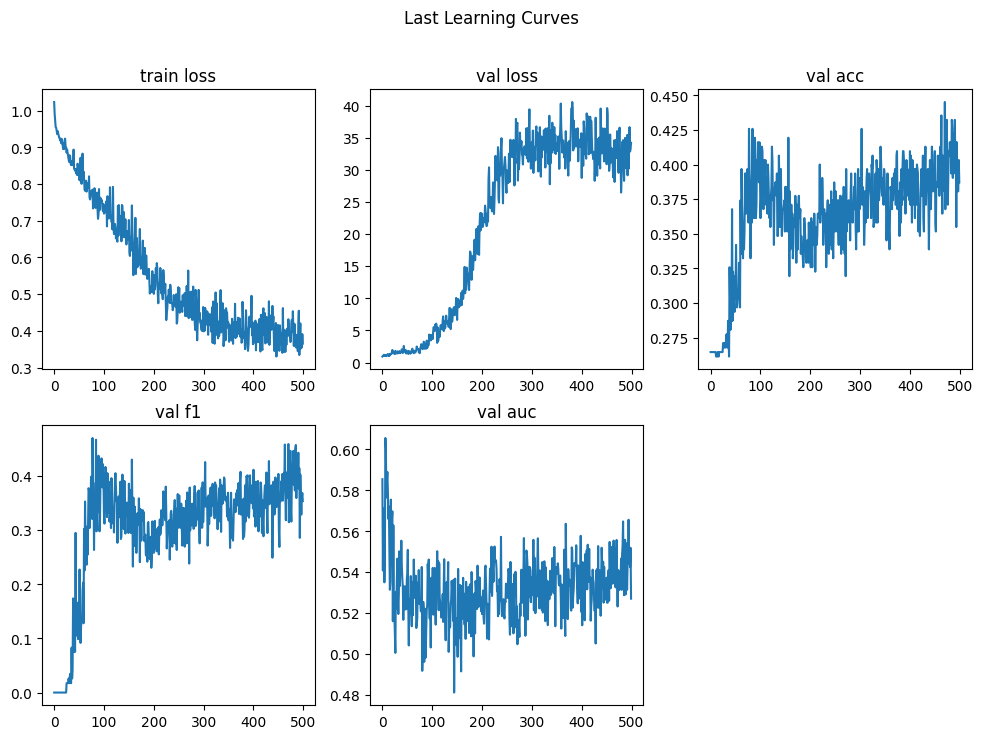

val acc mean:  0.2645161290322581
val f1 mean:  0.0
val auc mean:  0.5068463842533162


In [24]:
evaluate("SetTransformer")

==================SetCoAttnTransformer================


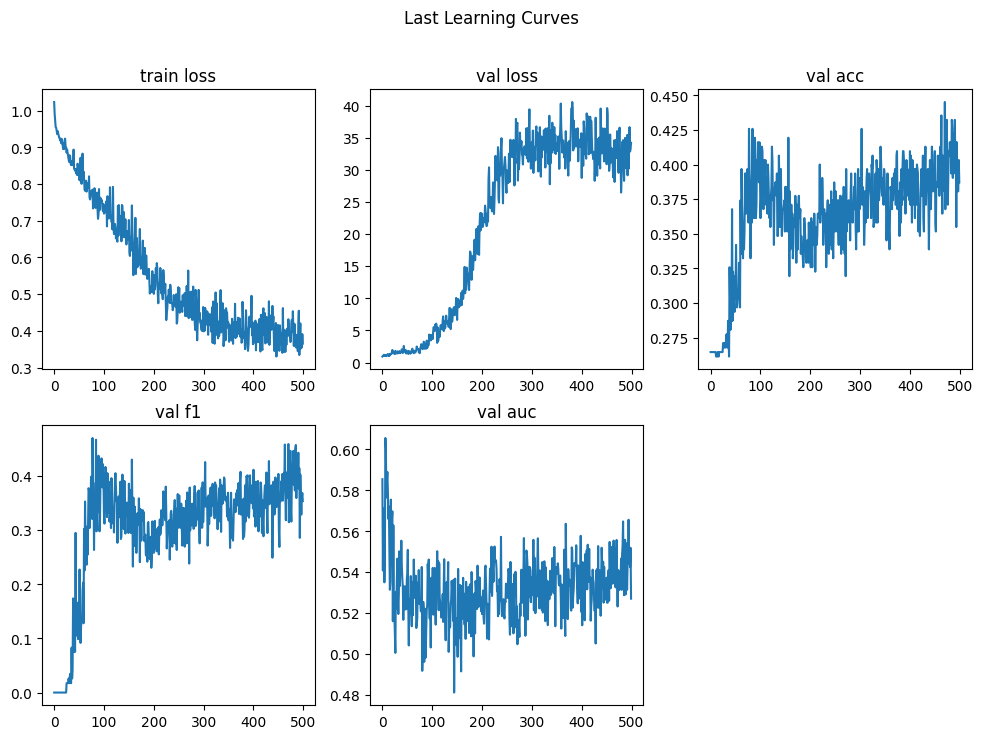

val acc mean:  0.2645161290322581
val f1 mean:  0.0
val auc mean:  0.5854193410355156


In [25]:
evaluate("SetCoAttnTransformer")

==================PESI================


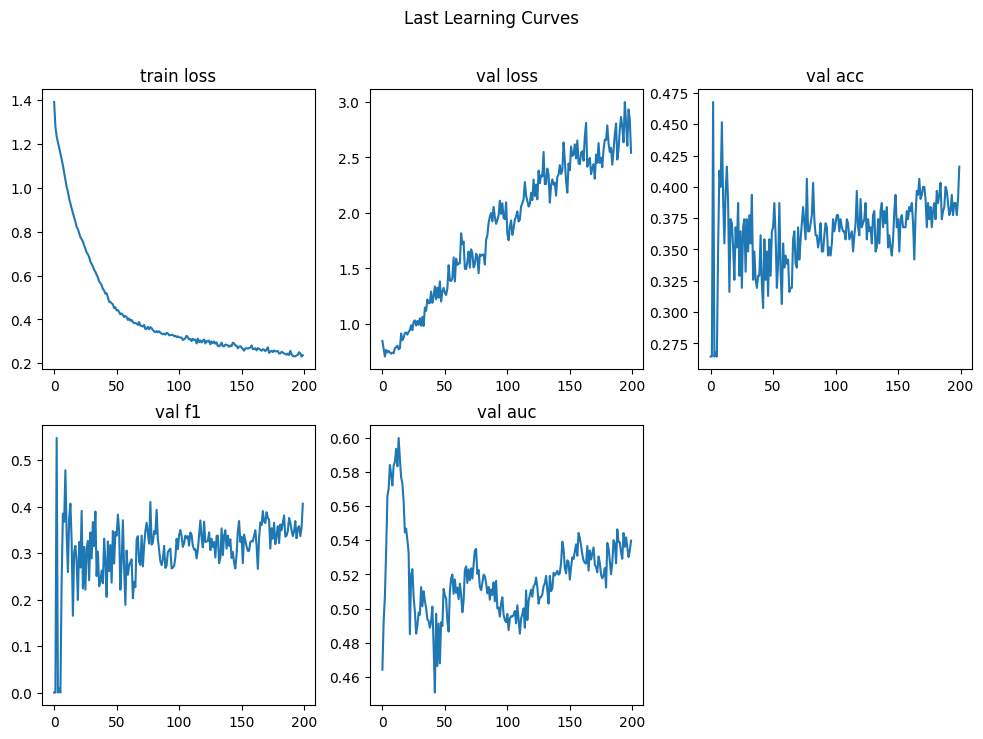

val acc mean:  0.46774193548387094
val f1 mean:  0.5479452054794519
val auc mean:  0.5071673085151904


In [20]:
evaluate("PESI")